In [1]:
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
    
class Driver:
    def __init__(self, type, start_time):
        self.type = type
        self.start_time = start_time
        self.actions = {}

def transform_time(time):
    t = datetime.strptime(time, '%H:%M')
    return t.hour * 60 + t.minute

def is_peak_time(minutes):
    time = (datetime(100, 1, 1) + timedelta(minutes=minutes)).time()
    return (datetime.strptime("07:00", "%H:%M").time() <= time < datetime.strptime("09:00", "%H:%M").time()) or (datetime
            .strptime("17:00", "%H:%M").time() <= time < datetime.strptime("19:00", "%H:%M").time())

def gen_initial_population():
    population = []
    for _ in range(300):
        drivers_list = []
        for i in range(8):
            start_time = random.choice(range(transform_time("06:00"), transform_time("18:00") + 1, 60))
            type = random.choice(["A", "B"])
            drivers_list.append(Driver(type, start_time))
        population.append(drivers_list)
    return population

def evaluation(drivers_list):
    score = 0

    for d in drivers_list:
        end_time = d.start_time + 8 * 60

        if d.type == "A":
            breaks = [d.start_time + 4 * 60]
        else:
            breaks = [d.start_time + 3 * 60, d.start_time + 6 * 60]

        if is_peak_time(d.start_time):
            score += 20
        else:
            score -= 10

        for break_time in breaks:
            if is_peak_time(break_time):
                score -= 50

        if end_time > transform_time("03:00"):
            score -= 30

        if d.start_time < transform_time("06:00") or d.start_time > transform_time("18:00"):
            score -= 50

    return score

def tournament(population, evaluations):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, evaluations)), 5)
        tournament = sorted(tournament, key=lambda x: x[1], reverse=True)
        selected.append(tournament[0][0])
    return selected

def crossover(a, b):
    point = random.randint(1, len(a) - 1)
    child1 = a[:point] + b[point:]
    child2 = b[:point] + a[point:]
    return child1, child2

def mutate(drivers_list):
    mutated_drivers = drivers_list[:]
    for i in range(len(mutated_drivers)):
        if random.randint(1, 10) == 1:
            start_time = random.choice(range(transform_time("06:00"), transform_time("18:00") + 1, 60))
            break_type = random.choice(["A", "B"])
            mutated_drivers[i] = Driver(break_type, start_time)
    return mutated_drivers

def genetic_method():
    population = gen_initial_population()
    evaluation_history = []

    for gen in range(100):
        evaluations = [evaluation(x) for x in population]
        evaluation_history.append(max(evaluations))

        selected = tournament(population, evaluations)

        new_population = []
        for i in range(0, len(selected), 2):
            new_population.extend(list(crossover(selected[i], selected[i + 1] if i + 1 < len(selected) else selected[0])))

        population = [mutate(x) for x in new_population]

        population = sorted(population, key=lambda x: evaluation(x), reverse=True)[:300]

        if gen % 10 == 0:
            print(f"Поколение {gen}: Лучшая приспособленность = {max(evaluations)}")

    best_drivers_list = population[0]
    return best_drivers_list, evaluation_history




Поколение 0: Лучшая приспособленность = -140
Поколение 10: Лучшая приспособленность = -80
Поколение 20: Лучшая приспособленность = -80
Поколение 30: Лучшая приспособленность = -80
Поколение 40: Лучшая приспособленность = -80
Поколение 50: Лучшая приспособленность = -80
Поколение 60: Лучшая приспособленность = -80
Поколение 70: Лучшая приспособленность = -80
Поколение 80: Лучшая приспособленность = -80
Поколение 90: Лучшая приспособленность = -80


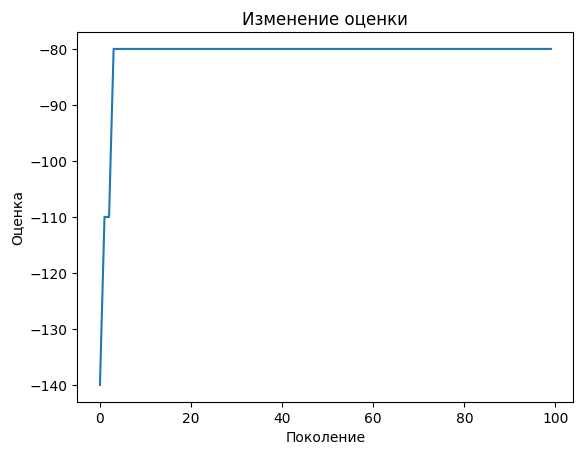

In [2]:
from openpyxl import Workbook

drivers_list, evaluation_history = genetic_method()

for i, d in enumerate(drivers_list):
    current_time = d.start_time

    d.actions[current_time] = "Смена началась"
    for hour in range(8):
        current_time += 60
        if d.type == "B" and hour in [3, 6]:
            d.actions[current_time] = "Перерыв 15 минут"
            current_time += 15
        elif d.type == "A" and hour == 4:
            d.actions[current_time] =  "Перерыв 1 час"
            current_time += 60
        else:
            d.actions[current_time] = "Выезд"

    d.actions[current_time] = "Смена завершена"
    drivers_list[i] = d

times = set()
for d in drivers_list:
    for t in list(d.actions.keys()):
        times.add(t)


times = sorted(list(times))
times_new = [(datetime(100, 1, 1) + timedelta(minutes=(x % 1440))).strftime('%H:%M') for x in times]

wb = Workbook()
ws = wb.active

first_line = [""]
for t in times_new:
    first_line.append(t)
ws.append(first_line)
for i, d in enumerate(drivers_list):
    data = [f"Водитель №{i + 1}"]
    for t in times:
        if t in list(d.actions.keys()):
            data.append(d.actions[t])
        else:
            data.append("-")
    ws.append(data)

wb.save("schedule2.xlsx")


plt.plot(evaluation_history)
plt.xlabel('Поколение')
plt.ylabel('Оценка')
plt.title('Изменение оценки')
plt.show()
